# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
from skimage import io
from skimage.util import crop
from skimage.transform import resize
import datetime
import os
import matplotlib.pyplot as plt

C:\Users\Rishi_Riddhi\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.compat.v1.set_random_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
train_doc = np.random.permutation(open('train.csv').readlines())
val_doc = np.random.permutation(open('val.csv').readlines())


In [4]:
# Initialize some variables
batch_size = 10 #experiment with the batch size
image_height = 100
image_width = 100

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [5]:
def generator(source_path, folder_list, batch_size):
  #  print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [1,5,9,13,17,21,25,29] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int (t.size / batch_size) # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(img_idx),image_height,image_width,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = io.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image_resized = resize(image, (image_height, image_width), anti_aliasing=True)
                    
                    batch_data[folder,idx,:,:,0] = image_resized[:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image_resized[:,:,1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image_resized[:,:,2]/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if ((t.size%batch_size) != 0):
            last_batch_size = t.size - (num_batches * batch_size)
            last_batch_data = np.zeros((last_batch_size,len(img_idx),image_height,image_width,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            last_batch_labels = np.zeros((last_batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(last_batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*last_batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = io.imread(source_path+'/'+ t[folder + (num_batches*last_batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image_resized = resize(image, (image_height, image_width), anti_aliasing=True)

                    last_batch_data[folder,idx,:,:,0] = image_resized[:,:,0]/255 #normalise and feed in the image
                    last_batch_data[folder,idx,:,:,1] = image_resized[:,:,1]/255 #normalise and feed in the image
                    last_batch_data[folder,idx,:,:,2] = image_resized[:,:,2]/255 #normalise and feed in the image

                last_batch_labels[folder, int(t[folder + (num_batches*last_batch_size)].strip().split(';')[2])] = 1
            yield last_batch_data, last_batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [6]:
curr_dt_time = datetime.datetime.now()
train_path = './train'
val_path = './val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [7]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, LSTM
from keras.layers import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from tensorflow.keras.optimizers import Adam



Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [8]:
#write your model here

model = Sequential()

model.add(Conv3D(16, 3, activation = 'relu', padding = 'same', input_shape = (8, image_height,image_width,3)))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(32, 3, activation = 'relu', padding = 'same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(64, 3, activation = 'relu', padding = 'same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.25))

model.add(Dense(5, activation = 'softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [9]:
optimiser = Adam(learning_rate=0.001)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 8, 100, 100, 16)   1312      
                                                                 
 max_pooling3d (MaxPooling3  (None, 4, 50, 50, 16)     0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 4, 50, 50, 16)     0         
                                                                 
 conv3d_1 (Conv3D)           (None, 4, 50, 50, 32)     13856     
                                                                 
 max_pooling3d_1 (MaxPoolin  (None, 2, 25, 25, 32)     0         
 g3D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 2, 25, 25, 32)     0

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [10]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [11]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
print (model_name)
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
#print (filepath)

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=0.0001)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

model_init_2024-04-0520_21_29.965371/


The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [12]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1
print (steps_per_epoch)
    
if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
print (validation_steps)

67
10


Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [13]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

C:\Users\Rishi_Riddhi\AppData\Local\Temp\ipykernel_16116\3383535347.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/20

67/67 [==============================] - ETA: 0s - loss: 1.6481 - categorical_accuracy: 0.2051
Epoch 1: saving model to model_init_2024-04-0520_21_29.965371\model-00001-1.64812-0.20513-1.57847-0.23000.h5
67/67 [==============================] - 114s 2s/step - loss: 1.6481 - categorical_accuracy: 0.2051 - val_loss: 1.5785 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/20


C:\Users\Rishi_Riddhi\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


67/67 [==============================] - ETA: 0s - loss: 1.5363 - categorical_accuracy: 0.3333
Epoch 2: saving model to model_init_2024-04-0520_21_29.965371\model-00002-1.53633-0.33333-1.27744-0.45000.h5
67/67 [==============================] - 101s 2s/step - loss: 1.5363 - categorical_accuracy: 0.3333 - val_loss: 1.2774 - val_categorical_accuracy: 0.4500 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 1.1858 - categorical_accuracy: 0.5023
Epoch 3: saving model to model_init_2024-04-0520_21_29.965371\model-00003-1.18579-0.50226-0.87205-0.72000.h5
67/67 [==============================] - 62s 933ms/step - loss: 1.1858 - categorical_accuracy: 0.5023 - val_loss: 0.8721 - val_categorical_accuracy: 0.7200 - lr: 0.0010
Epoch 4/20
67/67 [==============================] - ETA: 0s - loss: 0.9301 - categorical_accuracy: 0.6003
Epoch 4: saving model to model_init_2024-04-0520_21_29.965371\model-00004-0.93008-0.60030-0.69999-0.78000.h5
67/67 [=======================

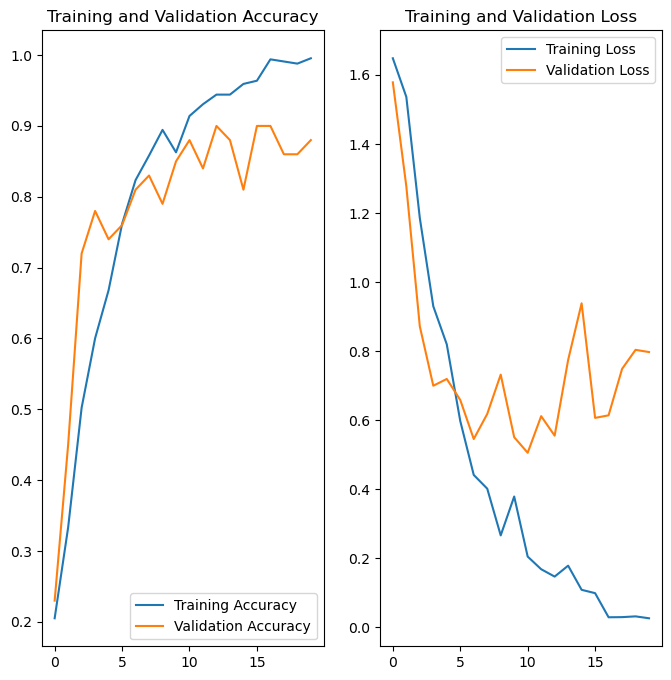

In [14]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [15]:
# Few experiments were conducted with the parameters like batch size, number of frames, image size, number of convolution layers. 
# The experiments have been documented in the write-up


In [16]:
lstm_model = Sequential()

lstm_model.add(Conv3D(16, 3, activation = 'relu', padding = 'same', input_shape = (8, image_height, image_width,3)))
lstm_model.add(MaxPooling3D(pool_size=(2, 2, 2)))
lstm_model.add(Dropout(0.25))

lstm_model.add(Conv3D(32, 3, activation = 'relu', padding = 'same'))
lstm_model.add(MaxPooling3D(pool_size=(2, 2, 2)))
lstm_model.add(Dropout(0.25))

lstm_model.add(Conv3D(64, 3, activation = 'relu', padding = 'same'))
lstm_model.add(MaxPooling3D(pool_size=(2, 2, 2)))
lstm_model.add(Dropout(0.25))

lstm_model.add(TimeDistributed(Flatten()))

lstm_model.add(LSTM(32))

lstm_model.add(Dense(128, activation = 'relu'))
lstm_model.add(Dropout(0.25))

lstm_model.add(Dense(5, activation = 'softmax'))

In [17]:
optimiser = Adam(learning_rate=0.001)
lstm_model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (lstm_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 8, 100, 100, 16)   1312      
                                                                 
 max_pooling3d_3 (MaxPoolin  (None, 4, 50, 50, 16)     0         
 g3D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 4, 50, 50, 16)     0         
                                                                 
 conv3d_4 (Conv3D)           (None, 4, 50, 50, 32)     13856     
                                                                 
 max_pooling3d_4 (MaxPoolin  (None, 2, 25, 25, 32)     0         
 g3D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 2, 25, 25, 32)    

In [18]:
history = lstm_model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

C:\Users\Rishi_Riddhi\AppData\Local\Temp\ipykernel_16116\129012674.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = lstm_model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/20
67/67 [==============================] - ETA: 0s - loss: 1.4743 - categorical_accuracy: 0.3107
Epoch 1: saving model to model_init_2024-04-0520_21_29.965371\model-00001-1.47425-0.31071-1.48993-0.26000.h5
67/67 [==============================] - 50s 721ms/step - loss: 1.4743 - categorical_accuracy: 0.3107 - val_loss: 1.4899 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 1.2143 - categorical_accuracy: 0.4887
Epoch 2: saving model to model_init_2024-04-0520_21_29.965371\model-00002-1.21428-0.48869-0.94901-0.68000.h5
67/67 [==============================] - 49s 740ms/step - loss: 1.2143 - categorical_accuracy: 0.4887 - val_loss: 0.9490 - val_categorical_accuracy: 0.6800 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 1.0336 - categorical_accuracy: 0.5747
Epoch 3: saving model to model_init_2024-04-0520_21_29.965371\model-00003-1.03363-0.57466-0.97311-0.58000.h5
67/67 [==========

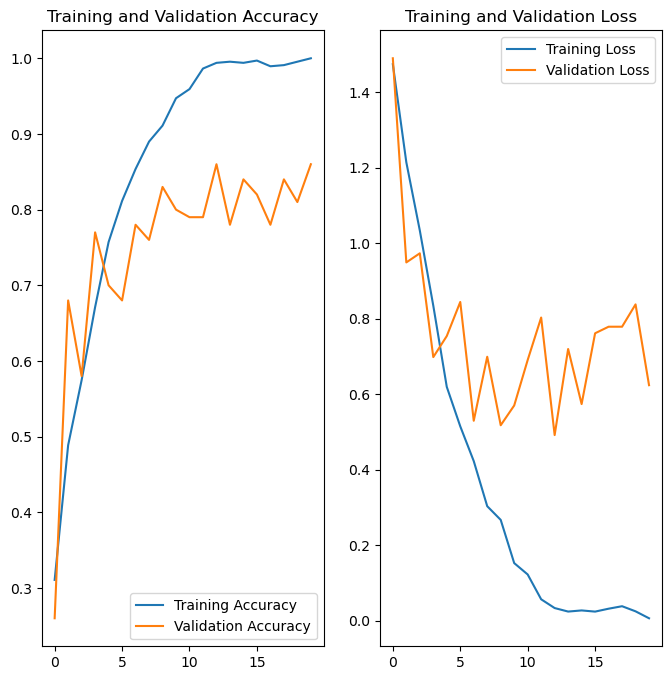

In [19]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [20]:
# Final experiment conducted with LSTM - The accuracy is not very different from the simple Conv3d model.